# Benchmarking Our Algorithm against others

In [1]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.PIBT import PIBT_plan
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [4]:

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(2,11,2))
# n_agents = [6]

TIMEOUT = 60 # 1 minute timeout

# Algorithms
algs = {  "PIBT": lambda hg: PIBT_plan(hg,vmax,bloating_r,TIMEOUT),
        "S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning",TIMEOUT=TIMEOUT)[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning")[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r,TIMEOUT=TIMEOUT),
        "Seq_Tube": lambda hg: sequential_planning(Tube_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT),      
        # "Seq_Temp_Obs": lambda hg: sequential_planning(Simple_MILP_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT)
        }

timeouted = {alg:False for alg in algs}

results = []

env_name = "MultiTunnel"


# Experiments
for i in range(len(n_agents)):
    N = n_agents[i]
    env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5, N_agent = N)
    HG = HybridGraph(env,bloating_r)
    to_remove = []
    for e in HG.edges:
        if HG.edges[e]['type']=='soft':
            # HG.edges[e]['weight'] = 0
            # pass
            u,v = e
            if HG.nodes[u]['type']== HG.nodes[v]['type']=='tunnel' and \
                                    HG.nodes[u]['open_space_id'] == HG.nodes[v]['open_space_id']:
                to_remove.append(e) # Remove the soft edges connecting two tunnel endpoints for this particular environment
    for e in to_remove:
        HG.remove_edge(*e)

    for name,alg in algs.items():

        if timeouted[name]:
            continue
        
        print("Alg:", name, "N agent:",N)

        result = {}
        
        t0 = time()
        plan = alg(HG)
        t = time()-t0
        
        result['plan'] = plan
        result['time'] = t

        result['N_agent'] = N
        result['alg_name'] = name

        result["TIMEOUT"]=TIMEOUT
        result["HG"]=HG

        results.append(result)

        
        if t>TIMEOUT:
            timeouted[name] = True
            print("Time out for algorithm", name, "N agent = ", N)


        
        

    # Save checkpoint data
    with open("./data/{}.pkl".format(env_name),'wb') as fp:
        pkl.dump(results,fp)


Alg: PIBT N agent: 2
Alg: S2M2 N agent: 2
Alg: PBS_Tube N agent: 2
Alg: TAHP N agent: 2
Planning for 0/2
Planning for 1/2
Alg: Seq_Tube N agent: 2
Alg: PIBT N agent: 4
Alg: S2M2 N agent: 4
PBS Time Elapsed: 0.30237817764282227
PBS Time Elapsed: 0.39147496223449707
Alg: PBS_Tube N agent: 4
PBS Time Elapsed: 0.293079137802124
PBS Time Elapsed: 0.365009069442749
PBS Time Elapsed: 0.4414479732513428
PBS Time Elapsed: 0.5423340797424316
PBS Time Elapsed: 0.6228601932525635
PBS Time Elapsed: 0.724498987197876
PBS Time Elapsed: 0.8605241775512695
Alg: TAHP N agent: 4
Planning for 0/4
Planning for 1/4
Planning for 2/4
Planning for 3/4
Alg: Seq_Tube N agent: 4
Alg: PIBT N agent: 6
Alg: S2M2 N agent: 6
PBS Time Elapsed: 0.36041998863220215
PBS Time Elapsed: 0.4746851921081543
Alg: PBS_Tube N agent: 6
PBS Time Elapsed: 0.3469889163970947
PBS Time Elapsed: 0.4149048328399658
PBS Time Elapsed: 0.48755693435668945
PBS Time Elapsed: 0.6140379905700684
PBS Time Elapsed: 0.7091138362884521
PBS Time Ela

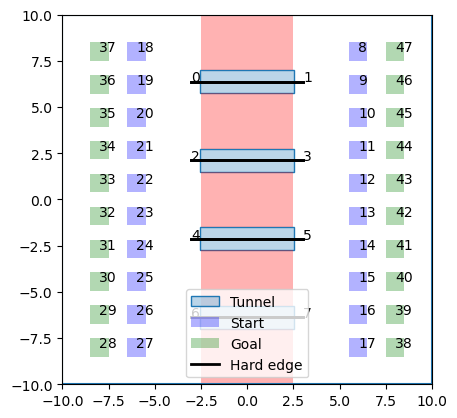

In [3]:
from panav.viz import draw_hybrid
# # Save checkpoint data
# with open("./data/{}_misc.pkl".format(env_name),'wb') as fp:
#     pkl.dump({"TIMEOUT":TIMEOUT,"HG":HG},fp)

draw_hybrid(HG)